### Agent-Lab: Coordinator -> Planner -> Supervisor Agent

Objective of this notebook is evaluating and adapting the architecture of [LangManus Hierarchical Agent](https://github.com/langmanus/langmanus?tab=readme-ov-file#architecture).

#### Preparation steps:

Before executing the notebook perform the following preparation steps.

1. Start Docker containers: `docker compose up -d --build`

2. Verify application is up and running, with web browser: `http://localhost:18000/docs`

3. Inside project root directory, create a `.env` file with env vars with correct values:

    ```
    DEVELOPING="True"
    OLLAMA_ENDPOINT="http://localhost:11434"
    TAVILY_API_KEY="???"
    XAI_API_KEY="???"
    ```

---

In [1]:
%%capture

import os
os.chdir('..')

from dotenv import load_dotenv
load_dotenv()

from notebooks import experiment_utils
from app.core.container import Container
from app.interface.api.messages.schema import MessageRequest

# start dependency injection container
container = Container()
container.init_resources()
container.wire(modules=[__name__])

In [2]:
# create agent
agent = experiment_utils.create_ollama_agent(
    agent_type="coordinator_planner_supervisor",
    llm_tag="mistral-small:24b",
    ollama_endpoint=os.getenv("OLLAMA_ENDPOINT")
)

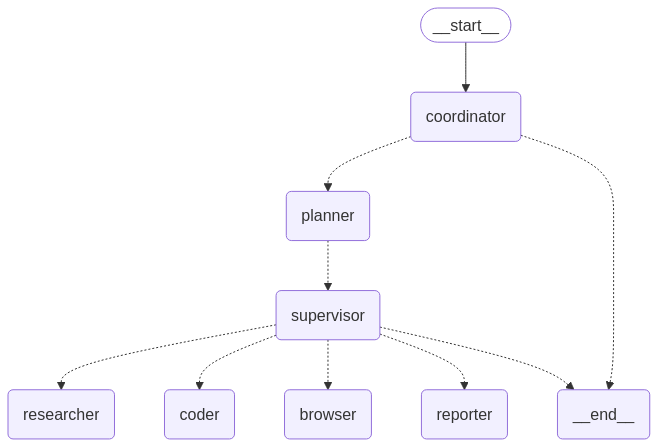

In [3]:
# get agent instance
coordinator_planner_supervisor_agent = container.coordinator_planner_supervisor_agent()

# get checkpointer instance
graph_persistence_factory = container.graph_persistence_factory()
checkpointer = graph_persistence_factory.build_checkpoint_saver()

# Create Graph
workflow_builder = coordinator_planner_supervisor_agent.get_workflow_builder(agent["id"])
workflow = workflow_builder.compile(checkpointer=checkpointer)
experiment_utils.print_graph(workflow)

In [4]:
agent_config = {
    "configurable": {
        "thread_id": agent["id"],
    },
    "recursion_limit": 30
}

In [5]:
%%capture
message = MessageRequest(
    message_role="human",
    message_content="What characterizes a good general according to Sun Tzu?",
    agent_id=agent["id"]
)

inputs = coordinator_planner_supervisor_agent.get_input_params(message)
result = workflow.invoke(inputs, agent_config)
print(result["messages"][-1].content)

KeyboardInterrupt: 